In [1]:
import torch
import sys
sys.path.append("../")
from ad_utils import *
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

cuda0 = torch.device("cuda:0")
cuda1 = torch.device("cuda:1")
device = cuda0
print(torch.cuda.get_device_name(device) if torch.cuda.is_available() else "No GPU available")

data = np.load("../../hvcm/RFQ.npy", allow_pickle=True)
label = np.load("../../hvcm/RFQ_labels.npy", allow_pickle=True)
label = label[:, 1]  # Assuming the second column is the label
label = (label == "Fault").astype(int)  # Convert to binary labels
print(data.shape, label.shape)

scaler = StandardScaler()
data = scaler.fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)

normal_data = data[label == 0]
faulty_data = data[label == 1]

normal_label = label[label == 0]
faulty_label = label[label == 1]

X_train_normal, X_test_normal, y_train_normal, y_test_normal = train_test_split(normal_data, normal_label, test_size=0.2, random_state=42, shuffle=True)
X_train_faulty, X_test_faulty, y_train_faulty, y_test_faulty = train_test_split(faulty_data, faulty_label, test_size=0.2, random_state=42, shuffle=True)

NVIDIA A100-PCIE-40GB
(872, 4500, 14) (872,)


# Vanilla GAN

In [2]:
# Optimized Vanilla GAN Generator for Multivariate Time Series
class VanillaGANGenerator(nn.Module):
    def __init__(self, latent_dim=100, n_features=14, seq_len=4500):
        super(VanillaGANGenerator, self).__init__()
        self.latent_dim = latent_dim
        self.n_features = n_features
        self.seq_len = seq_len
        
        # Calculate initial size for efficient upsampling
        self.init_size = seq_len // 32  # More efficient starting point
        
        # Initial projection with better capacity
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 256 * self.init_size),
            nn.BatchNorm1d(256 * self.init_size),
            nn.ReLU(inplace=True)
        )
        
        # Multi-scale upsampling blocks optimized for time series
        self.conv_blocks = nn.Sequential(
            # 256 -> 128 channels
            nn.ConvTranspose1d(256, 128, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            
            # 128 -> 64 channels  
            nn.ConvTranspose1d(128, 64, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            
            # 64 -> 32 channels
            nn.ConvTranspose1d(64, 32, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            
            # 32 -> 16 channels
            nn.ConvTranspose1d(32, 16, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(16),
            nn.ReLU(inplace=True),
            
            # 16 -> n_features channels
            nn.ConvTranspose1d(16, n_features, kernel_size=5, stride=2, padding=2),
            nn.Tanh()
        )
        
    def forward(self, z):
        # Project latent to initial conv size
        out = self.fc(z)
        out = out.view(out.shape[0], 256, self.init_size)
        
        # Progressive upsampling
        out = self.conv_blocks(out)
        
        # Ensure exact sequence length
        if out.shape[2] != self.seq_len:
            out = nn.functional.interpolate(out, size=self.seq_len, mode='linear', align_corners=False)
        
        # Return as (batch_size, seq_len, n_features)
        return out.transpose(1, 2)

# Optimized Vanilla GAN Discriminator for Multivariate Time Series
class VanillaGANDiscriminator(nn.Module):
    def __init__(self, n_features=14, seq_len=4500):
        super(VanillaGANDiscriminator, self).__init__()
        
        # Multi-scale feature extraction for time series
        self.conv_blocks = nn.Sequential(
            # n_features -> 32 channels
            nn.Conv1d(n_features, 32, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            
            # 32 -> 64 channels
            nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            
            # 64 -> 128 channels
            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            
            # 128 -> 256 channels
            nn.Conv1d(128, 256, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            
            # 256 -> 512 channels
            nn.Conv1d(256, 512, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        # Calculate output size after convolutions
        self.conv_output_size = self._get_conv_output_size(seq_len)
        
        # Enhanced classifier for better discrimination
        self.classifier = nn.Sequential(
            nn.Linear(512 * self.conv_output_size, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
    def _get_conv_output_size(self, seq_len):
        size = seq_len
        for _ in range(5):  # 5 conv layers
            size = (size + 2*2 - 5) // 2 + 1
        return size
    
    def forward(self, x):
        # Input: (batch_size, seq_len, n_features)
        x = x.transpose(1, 2)  # Convert to (batch_size, n_features, seq_len)
        
        # Apply conv blocks
        features = self.conv_blocks(x)
        
        # Flatten and classify
        features = features.view(features.size(0), -1)
        output = self.classifier(features)
        
        return output

# Enhanced Vanilla GAN training function for time series - BALANCED VERSION
def train_vanilla_gan(normal_data, device, n_epochs=50, batch_size=16, lr_g=1e-4, lr_d=2e-4):
    """
    Train Vanilla GAN optimized for multivariate time series with balanced training
    """
    print(f"Starting Balanced Vanilla GAN Training for Time Series")
    print(f"Data shape: {normal_data.shape}")
    print(f"Raw data range: [{normal_data.min():.4f}, {normal_data.max():.4f}]")
    
    # Improved data preprocessing for time series
    data_mean = np.mean(normal_data, axis=(0, 1), keepdims=True)
    data_std = np.std(normal_data, axis=(0, 1), keepdims=True) + 1e-8
    
    # Normalize with better range preservation
    normalized_data = (normal_data - data_mean) / data_std
    normalized_data = np.clip(normalized_data, -3, 3)  # Clip outliers
    normalized_data = normalized_data / 3.0  # Scale to [-1, 1] approximately
    
    print(f"Normalized data range: [{normalized_data.min():.4f}, {normalized_data.max():.4f}]")
    
    # Model parameters
    latent_dim = 128  # Increased for better representation
    n_features = normalized_data.shape[-1]
    seq_len = normalized_data.shape[1]
    
    # Initialize models
    generator = VanillaGANGenerator(latent_dim, n_features, seq_len).to(device)
    discriminator = VanillaGANDiscriminator(n_features, seq_len).to(device)
    
    # Improved weight initialization for time series
    def init_weights(m):
        if isinstance(m, (nn.Conv1d, nn.ConvTranspose1d)):
            nn.init.normal_(m.weight, 0.0, 0.02)
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm1d):
            nn.init.normal_(m.weight, 1.0, 0.02)
            nn.init.constant_(m.bias, 0)
    
    generator.apply(init_weights)
    discriminator.apply(init_weights)
    
    # BALANCED optimizers - Lower discriminator LR, higher generator LR
    optimizer_G = optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))
    
    # Loss function
    criterion = nn.BCELoss()
    
    # Create dataloader with smaller batch size for memory efficiency
    dataset = TensorDataset(torch.tensor(normalized_data, dtype=torch.float32))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    
    print(f"Training Parameters:")
    print(f"  Epochs: {n_epochs}, Batch Size: {batch_size}")
    print(f"  Generator LR: {lr_g}, Discriminator LR: {lr_d}")
    print(f"  Latent Dimension: {latent_dim}")
    
    # Training history
    d_losses = []
    g_losses = []
    d_accuracies = []
    
    # Balance tracking
    d_train_freq = 1  # How often to train discriminator
    g_train_freq = 1  # How often to train generator
    
    print("\nStarting Balanced Training...")
    print("=" * 60)
    
    for epoch in range(n_epochs):
        epoch_d_losses = []
        epoch_g_losses = []
        epoch_d_accuracies = []
        
        for i, (real_samples,) in enumerate(dataloader):
            real_samples = real_samples.to(device)
            batch_size_actual = real_samples.size(0)
            
            # ADAPTIVE LABEL SMOOTHING - More aggressive when discriminator is too strong
            if len(d_accuracies) > 0 and d_accuracies[-1] > 0.8:
                # Strong label smoothing when D is too good
                real_labels = torch.ones(batch_size_actual, 1, device=device) * 0.7
                fake_labels = torch.zeros(batch_size_actual, 1, device=device) + 0.3
            else:
                # Normal label smoothing
                real_labels = torch.ones(batch_size_actual, 1, device=device) * 0.9
                fake_labels = torch.zeros(batch_size_actual, 1, device=device) + 0.1
            
            # ========================
            # ADAPTIVE DISCRIMINATOR TRAINING
            # ========================
            train_discriminator = True
            
            # Skip discriminator training if it's too strong
            if len(d_accuracies) > 5:
                recent_acc = np.mean(d_accuracies[-5:])
                if recent_acc > 0.85:
                    train_discriminator = (i % 3 == 0)  # Train D every 3rd iteration
                elif recent_acc > 0.75:
                    train_discriminator = (i % 2 == 0)  # Train D every 2nd iteration
            
            if train_discriminator:
                optimizer_D.zero_grad()
                
                # Real samples
                real_output = discriminator(real_samples)
                d_loss_real = criterion(real_output, real_labels)
                
                # Generate fake samples
                z = torch.randn(batch_size_actual, latent_dim, device=device)
                fake_samples = generator(z).detach()
                fake_output = discriminator(fake_samples)
                d_loss_fake = criterion(fake_output, fake_labels)
                
                # Total discriminator loss
                d_loss = d_loss_real + d_loss_fake
                d_loss.backward()
                optimizer_D.step()
                
                # Calculate discriminator accuracy
                real_pred = (real_output > 0.5).float()
                fake_pred = (fake_output > 0.5).float()
                d_accuracy = ((real_pred == torch.ones_like(real_pred)).sum() + 
                             (fake_pred == torch.zeros_like(fake_pred)).sum()).float() / (2 * batch_size_actual)
                
                epoch_d_losses.append(d_loss.item())
                epoch_d_accuracies.append(d_accuracy.item())
            
            # ========================
            # ENHANCED GENERATOR TRAINING
            # ========================
            # Train generator more frequently when discriminator is strong
            generator_iterations = 1
            if len(d_accuracies) > 0 and d_accuracies[-1] > 0.8:
                generator_iterations = 2  # Train G twice when D is too strong
            
            for _ in range(generator_iterations):
                optimizer_G.zero_grad()
                
                # Generate fake samples
                z = torch.randn(batch_size_actual, latent_dim, device=device)
                fake_samples = generator(z)
                fake_output = discriminator(fake_samples)
                
                # Generator loss
                g_loss = criterion(fake_output, torch.ones_like(fake_output))
                
                g_loss.backward()
                optimizer_G.step()
                
                epoch_g_losses.append(g_loss.item())
        
        # Calculate epoch averages
        avg_d_loss = np.mean(epoch_d_losses) if epoch_d_losses else 0
        avg_g_loss = np.mean(epoch_g_losses) if epoch_g_losses else 0
        avg_d_accuracy = np.mean(epoch_d_accuracies) if epoch_d_accuracies else 0.5
        
        d_losses.append(avg_d_loss)
        g_losses.append(avg_g_loss)
        d_accuracies.append(avg_d_accuracy)
        
        # ADAPTIVE LEARNING RATE ADJUSTMENT
        if epoch > 10:
            recent_acc = np.mean(d_accuracies[-5:])
            if recent_acc > 0.85:
                # Discriminator too strong - reduce its LR, increase generator LR
                for param_group in optimizer_D.param_groups:
                    param_group['lr'] *= 0.98
                for param_group in optimizer_G.param_groups:
                    param_group['lr'] *= 1.02
            elif recent_acc < 0.3:
                # Generator too strong - increase discriminator LR, reduce generator LR  
                for param_group in optimizer_D.param_groups:
                    param_group['lr'] *= 1.02
                for param_group in optimizer_G.param_groups:
                    param_group['lr'] *= 0.98
        
        # Print progress
        if epoch % 10 == 0 or epoch == n_epochs - 1:
            current_lr_g = optimizer_G.param_groups[0]['lr']
            current_lr_d = optimizer_D.param_groups[0]['lr']
            
            print(f"Epoch [{epoch+1:3d}/{n_epochs}] | "
                  f"D Loss: {avg_d_loss:8.4f} | "
                  f"G Loss: {avg_g_loss:8.4f} | "
                  f"D Acc: {avg_d_accuracy:6.3f} | "
                  f"LR_G: {current_lr_g:.5f} | LR_D: {current_lr_d:.5f}")
            
            # Check training stability
            if avg_d_accuracy < 0.3:
                print("         ⚠️  Generator overpowering discriminator")
            elif avg_d_accuracy > 0.8:
                print("         ⚠️  Discriminator overpowering generator") 
            elif 0.4 <= avg_d_accuracy <= 0.7:
                print("         ✅ Training appears balanced")
            else:
                print("         🔄 Adjusting balance...")
    
    print("=" * 60)
    print("Training completed!")
    
    # Store normalization parameters
    data_stats = (data_mean, data_std)
    
    return generator, discriminator, d_losses, g_losses, d_accuracies, data_stats


# Enhanced sample generation for time series
def generate_vanilla_samples(generator, num_samples, latent_dim, device, data_stats, batch_size=16):
    """
    Generate samples and denormalize them properly for time series
    """
    generator.eval()
    data_mean, data_std = data_stats
    
    generated_batches = []
    
    with torch.no_grad():
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            current_batch_size = end - start
            
            # Generate noise
            z = torch.randn(current_batch_size, latent_dim, device=device)
            
            # Generate samples
            batch_generated = generator(z)
            
            # Denormalize properly
            batch_generated = batch_generated.cpu().numpy()
            batch_generated = batch_generated * 3.0  # Reverse scaling
            batch_generated = batch_generated * data_std + data_mean
            
            generated_batches.append(batch_generated)
    
    return np.concatenate(generated_batches, axis=0)

# Visualization remains the same
def plot_vanilla_training_curves(d_losses, g_losses, d_accuracies):
    """
    Plot training curves for Vanilla GAN
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Discriminator loss
    axes[0].plot(d_losses, label='Discriminator Loss', color='blue', alpha=0.7)
    axes[0].set_title('Discriminator Loss Over Time')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Generator loss
    axes[1].plot(g_losses, label='Generator Loss', color='red', alpha=0.7)
    axes[1].set_title('Generator Loss Over Time')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Discriminator accuracy
    axes[2].plot(d_accuracies, label='Discriminator Accuracy', color='green', alpha=0.7)
    axes[2].axhline(y=0.5, color='black', linestyle='--', alpha=0.5, label='Random Guess')
    axes[2].set_title('Discriminator Accuracy Over Time')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Accuracy')
    axes[2].set_ylim(0, 1)
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Train, and generate

Training Balanced Vanilla GAN...
Starting Balanced Vanilla GAN Training for Time Series
Data shape: (552, 4500, 14)
Raw data range: [-5.7248, 7.6610]
Normalized data range: [-1.0000, 1.0000]
Training Parameters:
  Epochs: 300, Batch Size: 64
  Generator LR: 0.01, Discriminator LR: 1e-05
  Latent Dimension: 128

Starting Balanced Training...
Epoch [  1/300] | D Loss:   1.7288 | G Loss:   1.1103 | D Acc:  0.539 | LR_G: 0.01000 | LR_D: 0.00001
         ✅ Training appears balanced
Epoch [ 11/300] | D Loss:   0.9929 | G Loss:   1.3824 | D Acc:  0.873 | LR_G: 0.01000 | LR_D: 0.00001
         ⚠️  Discriminator overpowering generator
Epoch [ 21/300] | D Loss:   1.4585 | G Loss:   1.0076 | D Acc:  0.695 | LR_G: 0.01000 | LR_D: 0.00001
         ✅ Training appears balanced
Epoch [ 31/300] | D Loss:   1.2105 | G Loss:   1.0439 | D Acc:  0.733 | LR_G: 0.01000 | LR_D: 0.00001
         🔄 Adjusting balance...
Epoch [ 41/300] | D Loss:   1.1298 | G Loss:   1.2698 | D Acc:  0.816 | LR_G: 0.01000 | LR_D:

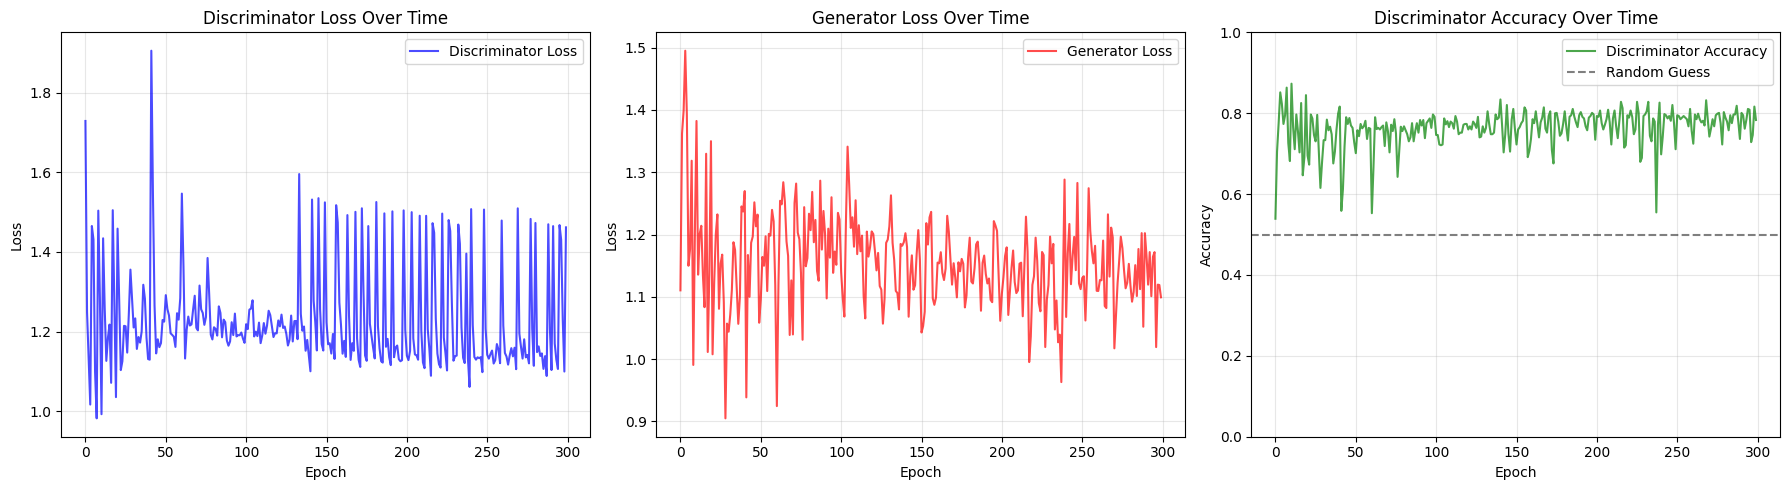

Generating synthetic samples...
Generated data shape: (552, 4500, 14)
Generated data range: [-3.1311, 3.1542]
Original data range: [-5.7248, 7.6610]


In [7]:
# Train with balanced parameters
print("Training Balanced Vanilla GAN...")
generator, discriminator, d_history, g_history, d_acc_history, data_stats = train_vanilla_gan(
    X_train_normal,
    device,
    n_epochs=300,
    batch_size=64,
    lr_g=0.01,  # Reduced generator LR
    lr_d=0.00001   # Much lower discriminator LR  
)

# Plot training curves
plot_vanilla_training_curves(d_history, g_history, d_acc_history)

# Generate samples
print("Generating synthetic samples...")
num_samples = len(X_train_normal)
generated_data = generate_vanilla_samples(
    generator,
    num_samples,
    latent_dim=128,
    device=device,
    data_stats=data_stats,
    batch_size=32
)

print(f"Generated data shape: {generated_data.shape}")
print(f"Generated data range: [{generated_data.min():.4f}, {generated_data.max():.4f}]")
print(f"Original data range: [{normal_data.min():.4f}, {normal_data.max():.4f}]")



# FID Score

In [10]:
# ===============================
# FID SCORE EVALUATION
# ===============================

# Test the simplified FID calculation
print("Testing simplified FID calculation...")

# Use smaller subsets for testing
test_real = X_train_normal[:100]  # Use 100 samples for testing
test_generated = generated_data[:100]

print(f"Test real data shape: {test_real.shape}")
print(f"Test generated data shape: {test_generated.shape}")

# Calculate FID score
fid_score = calculate_fid_score(
    real_data=test_real,
    fake_data=test_generated,
    device=device,
    sample_rate=1000,
)

if fid_score is not None:
    print(f"\n🎉 SUCCESS! FID Score: {fid_score:.4f}")
    
    # Interpret the score
    if fid_score < 10:
        quality = "Excellent"
    elif fid_score < 25:
        quality = "Good"
    elif fid_score < 50:
        quality = "Fair"
    elif fid_score < 100:
        quality = "Poor"
    else:
        quality = "Very Poor"
    
    print(f"Quality Assessment: {quality}")
else:
    print("❌ FID calculation failed. Please check the error messages above.")

Testing simplified FID calculation...
Test real data shape: (100, 4500, 14)
Test generated data shape: (100, 4500, 14)
Processing real data for FID...
Processing 100 samples for FID calculation (299x299)...
Processed 0/100 samples
Processing fake data for FID...
Processing 100 samples for FID calculation (299x299)...
Processed 0/100 samples
Calculating FID with 100 samples each...
Real images shape: torch.Size([100, 3, 299, 299])
Fake images shape: torch.Size([100, 3, 299, 299])
Real images range: [0.0000, 0.9816]
Fake images range: [0.0000, 0.9983]
After clamping - Real images range: [0.0000, 0.9816]
After clamping - Fake images range: [0.0000, 0.9983]
FID Score: 18.3489

🎉 SUCCESS! FID Score: 18.3489
Quality Assessment: Good



COMPREHENSIVE ANOMALY DETECTION CROSS-VALIDATION EXPERIMENT
Normal samples: 138
Faulty samples: 37
Generated samples: 552
Cross-validation folds: 5

========================= FOLD 1/5 =========================
Fold 1 - Train normal: 110
Fold 1 - Train faulty: 30
Fold 1 - Test: 35 (28 normal, 7 faulty)
Fold 1 - Augmented normal data: 662 samples
Processing data through feature extraction...
Processing 662 samples with multi-channel approach...
Processing 30 samples with multi-channel approach...
Processing 35 samples with multi-channel approach...
Training autoencoder...
Training Binary Classification SVM...

Fold 1 Results:
--------------------------------------------------
F1_Threshold       | Acc: 0.9143 | Prec: 0.7500 | Rec: 0.8571 | F1: 0.8000
Accuracy_Threshold | Acc: 0.9143 | Prec: 0.7500 | Rec: 0.8571 | F1: 0.8000
Binary_SVM         | Acc: 0.9143 | Prec: 1.0000 | Rec: 0.5714 | F1: 0.7273

========================= FOLD 2/5 =========================
Fold 2 - Train normal: 110
Fo

/home/maddie/SmartIoT-2025/GANs models/Vanilla GANs/../ad_utils.py:879: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(methods, rotation=45, ha='right')


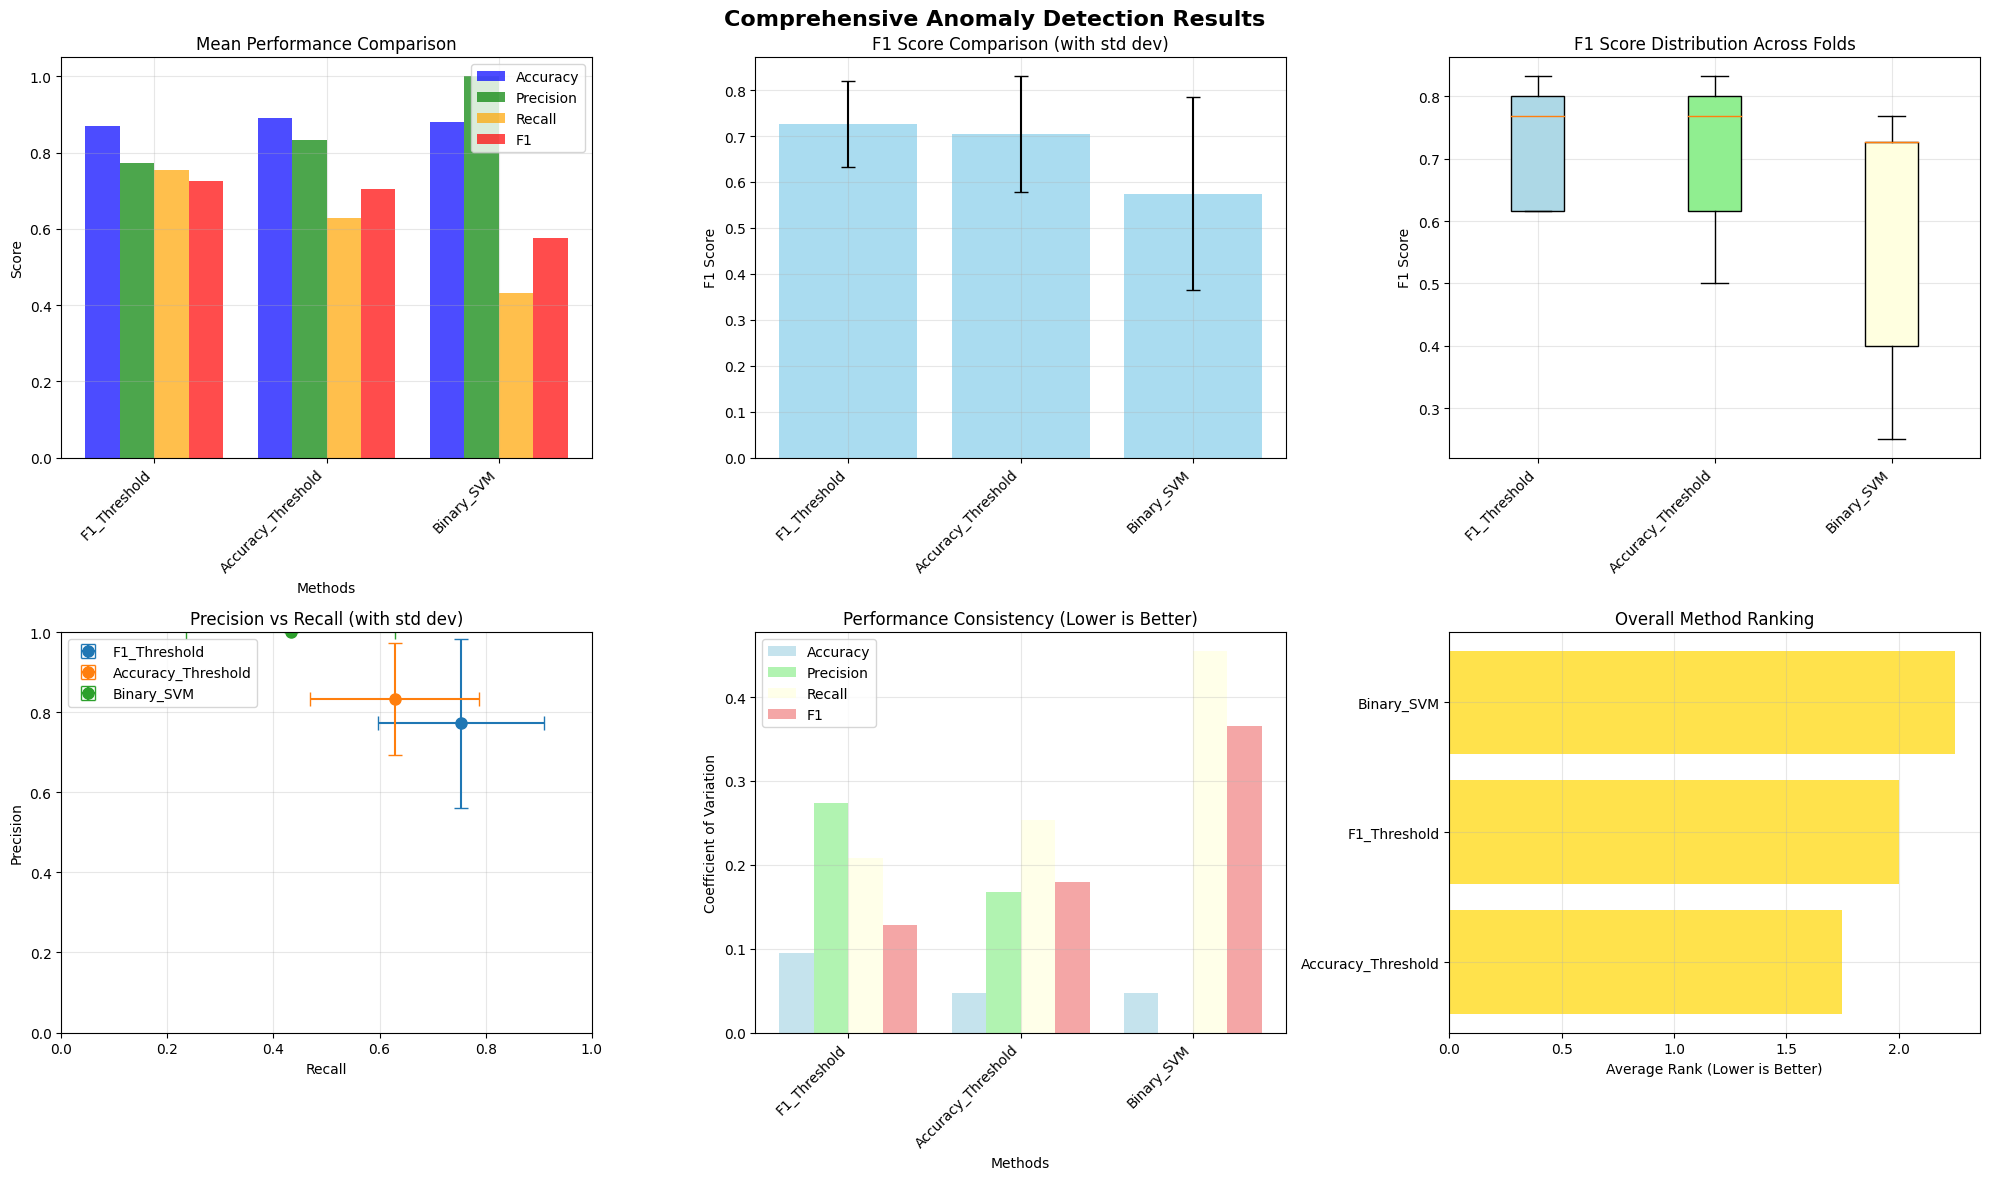


ANOMALY DETECTION RECOMMENDATIONS

🏆 BEST METHODS:
   • Best F1 Score: F1_Threshold (0.7267)
   • Best Accuracy: Accuracy_Threshold (0.8914)

📊 METHOD CHARACTERISTICS:
   • F1_Threshold          : Balanced precision and recall, Variable
   • Accuracy_Threshold    : High Precision (fewer false alarms), Variable
   • Binary_SVM            : High Precision (fewer false alarms), Variable

🎯 USE CASE RECOMMENDATIONS:
   • For Critical Systems (minimize false negatives): Use method with highest recall
   • For Cost-Sensitive Systems (minimize false alarms): Use method with highest precision
   • For Balanced Performance: Use F1_Threshold
   • For Simplicity: Use 95th_Percentile - no hyperparameter tuning needed
   • For Robustness: Use OneClass_SVM - adapts to data distribution



({'F1_Threshold': {'accuracy': {'mean': 0.8685714285714285,
    'std': 0.08201542911089897,
    'values': [0.9142857142857143,
     0.8571428571428571,
     0.9428571428571428,
     0.9142857142857143,
     0.7142857142857143]},
   'precision': {'mean': 0.7722222222222221,
    'std': 0.2111111111111111,
    'values': [0.75, 0.6666666666666666, 1.0, 1.0, 0.4444444444444444]},
   'recall': {'mean': 0.7535714285714286,
    'std': 0.15665508713900936,
    'values': [0.8571428571428571,
     0.5714285714285714,
     0.7142857142857143,
     0.625,
     1.0]},
   'f1': {'mean': 0.7266666666666667,
    'std': 0.09309634606978427,
    'values': [0.7999999999999999,
     0.6153846153846153,
     0.8333333333333333,
     0.7692307692307693,
     0.6153846153846153]}},
  'Accuracy_Threshold': {'accuracy': {'mean': 0.8914285714285715,
    'std': 0.04199125273342589,
    'values': [0.9142857142857143,
     0.8571428571428571,
     0.9428571428571428,
     0.9142857142857143,
     0.8285714285714286

In [12]:
run_comprehensive_cross_validation_experiment(X_test_normal, X_test_faulty, device, generated_data, batch_size=32)